# Molecular Informatics Project
### Created by: Karla Vela 
### Created on 10/25/24

<span style="color:red; font-size:35px; font-weight:bold">Step 1: Import libraries  </span>

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
from torch_geometric.utils import to_networkx
from torch.utils.tensorboard import SummaryWriter
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.transforms import Compose
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree
import numpy as np

In [21]:
## read in necessary data files
disgenet_with_features = pd.read_csv("../data/processed/disgene_final_dataset.tsv", sep='\t')
disgenet_with_features

new_disgenet_df= pd.read_csv("../data/processed/new_filtered_disgenet.tsv", sep='\t')
new_disgenet_df

filtered_biogrid= pd.read_csv("../data/processed/filtered_biogrid_df.tsv", sep='\t')

<span style="color:red; font-size:35px; font-weight:bold">Step 4: Create Pytorch data object </span>

>#### To be able to train the GAE, a pytorch data object is needed which is the core data structure used to represent graphs and in this case it will be a bipartite graph. This will contain your node features, edge index, edge features, labels, and other metadata that you want to include. Below are 3 functinos that will help create the pytorch data object. For this first GAE a pytorch data object containing disease and genes will be created. There will  be two sets of nodes: gene and disease nodes.

1. **node_mapping** - creates a mapping dictionary to keep track of the features/inputs. In this case we will have a mapping that will tell us what disease is what node and what gene is what node. 
2. **edge_list** - creates an edge list which tells us what genes are connected to what diseases. 
3. **get_data_with_features** - creates the actual pytorch data object using the disgenet_with_features data frame. 

In [22]:
# construct the pytroch data object to train models
def node_mapping(disgenet_df, index_col):
    mapping = {index_id: i for i, index_id in enumerate(disgenet_df[index_col].unique())}
    return mapping

In [23]:
def edge_list(disgenet_df, source_col, source_mapping, dst_col, dst_mapping):
    src_nodes = [source_mapping[index] for index in disgenet_df[source_col]]
    dst_nodes = [dst_mapping[index] for index in disgenet_df[dst_col]]
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

In [24]:

def get_data_with_features(disgenet_with_features, num_features):
    dis_col, gene_col = "mondo_id", "gene_id"
    
    # get the node index mappings
    map_dis_nodes = node_mapping(disgenet_with_features, dis_col)
    map_gene_nodes = node_mapping(disgenet_with_features, gene_col)
    
    # get edge index based on the index mappings
    edge_index = edge_list(disgenet_with_features, dis_col, map_dis_nodes, gene_col, map_gene_nodes)
    
    # add the reverse index to make it an undirected graph
    reverse_edge_index = edge_list(disgenet_with_features, gene_col, map_gene_nodes, dis_col, map_dis_nodes)
    
    # initialize the data object
    data = Data()
    data.num_nodes = len(map_dis_nodes) + len(map_gene_nodes)
    data.edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)
    
    # initialize disease features as ones
    dis_features = torch.ones((len(map_dis_nodes), num_features), dtype=torch.float32)
    
    # initialize gene features using the merged df
    gene_features_values = disgenet_with_features.drop_duplicates(subset='gene_id').set_index('gene_id')[['feature']].reindex(map_gene_nodes.keys()).fillna(0).values
    gene_features = torch.tensor(gene_features_values, dtype=torch.float32).view(-1, 1).expand(-1, num_features)
    
    # ensure the number of features match
    if gene_features.shape[1] < num_features:
        gene_features = torch.cat((gene_features, torch.ones(gene_features.shape[0], num_features - gene_features.shape[1])), dim=1)
    elif gene_features.shape[1] > num_features:
        gene_features = gene_features[:, :num_features]
    
    # combine features
    data.x = torch.cat((dis_features, gene_features), dim=0)

    return data, map_gene_nodes, map_dis_nodes

In [25]:
# declare number of features
num_features = 1

# call function that will create the pytorch data object
disgenet_torch_data, gene_mappings, disease_mappings = get_data_with_features(disgenet_with_features, num_features)


In [26]:
# take a look at what the pytorch data object looks like. x= how many features there are and how many are in that row. Ex. there are 18140 feautre in total but each node has 1 feature (1 confidence score value).
print(disgenet_torch_data)
print("Number of genes: ", len(gene_mappings))
print("Number of diseases: ", len(disease_mappings))

Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])
Number of genes:  11583
Number of diseases:  6557


In [27]:
# bring up dataframe for reference
disgenet_with_features

,gene_id,gene_name,mondo_id,mondo_term,feature
0,2,A2M,MONDO:0004975,Alzheimer disease,-3.774064
1,2,A2M,MONDO:0021063,malignant colon neoplasm,-3.774064
2,2,A2M,MONDO:0005401,colonic neoplasm,-3.774064
3,2,A2M,MONDO:0002050,depressive disorder,-3.774064
4,2,A2M,MONDO:0005376,membranous glomerulonephritis,-3.774064
...,...,...,...,...,...
160765,106783499,OPA8,MONDO:0002135,optic nerve disorder,0.000000
160766,106783499,OPA8,MONDO:0043878,hereditary optic atrophy,0.000000
160767,106783499,OPA8,MONDO:0020250,autosomal dominant optic atrophy,0.000000
160768,107305681,DHS6S1,MONDO:0005283,retinal disorder,0.000000


In [28]:
# look at the mapping dictionaries to see where each MONDO id is and their corresponding annotated gene. For instance MONDO:0004975 is in disease node 0 and it's annotated gene 2 is also in gene node 0.
# above you can see that the dataframe confirms the mappings are correct.
print(f"gene mappings: {gene_mappings}")
print(f"disease mappings: {disease_mappings}")

gene mappings: {2: 0, 9: 1, 10: 2, 12: 3, 15: 4, 16: 5, 18: 6, 19: 7, 20: 8, 21: 9, 22: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 29: 17, 31: 18, 32: 19, 33: 20, 34: 21, 35: 22, 36: 23, 37: 24, 38: 25, 39: 26, 40: 27, 41: 28, 43: 29, 47: 30, 48: 31, 49: 32, 50: 33, 51: 34, 53: 35, 54: 36, 55: 37, 58: 38, 59: 39, 60: 40, 70: 41, 71: 42, 72: 43, 81: 44, 86: 45, 87: 46, 88: 47, 90: 48, 91: 49, 92: 50, 93: 51, 94: 52, 95: 53, 100: 54, 102: 55, 103: 56, 104: 57, 105: 58, 107: 59, 108: 60, 109: 61, 111: 62, 112: 63, 113: 64, 114: 65, 115: 66, 116: 67, 117: 68, 118: 69, 119: 70, 120: 71, 123: 72, 125: 73, 126: 74, 127: 75, 128: 76, 131: 77, 132: 78, 133: 79, 134: 80, 135: 81, 140: 82, 142: 83, 143: 84, 146: 85, 147: 86, 148: 87, 150: 88, 151: 89, 152: 90, 153: 91, 154: 92, 155: 93, 156: 94, 157: 95, 158: 96, 161: 97, 162: 98, 163: 99, 165: 100, 166: 101, 172: 102, 173: 103, 174: 104, 175: 105, 176: 106, 177: 107, 178: 108, 181: 109, 182: 110, 183: 111, 185: 112, 186: 113, 187: 114, 

In [29]:
# save the pytorch data object to keep for future reference and so you don't have to run the whole script again.
torch.save(disgenet_torch_data, '../data/processed/disgenet_torch_data.pt')
new_disgenet_torch_data = torch.load('../data/processed/disgenet_torch_data.pt')
print(disgenet_torch_data)
print(new_disgenet_torch_data)

Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])
Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])


<span style="color:red; font-size:35px; font-weight:bold">Step 5: Visualize the bipartite graph</span>

>#### It's nice to visualize what the graph can look like so you can understand whiat the GAE will train on. REMEMBER this is only a veeeeeeery small section of the entire pytorch data object that was developed. If the whole thing were to be graphed two things would happen. 1) It would take forever for the code chunk to execute because the pytorch data object is masive. It has 18,000+ nodes and more than 300,000 edges to connect the nodes. This takes a lot of time to graph and 2) if it does execute the plot would look like a huge blob becase of the same issue that was addressed in #1; there's just too much to graph and it all clusters around each other.

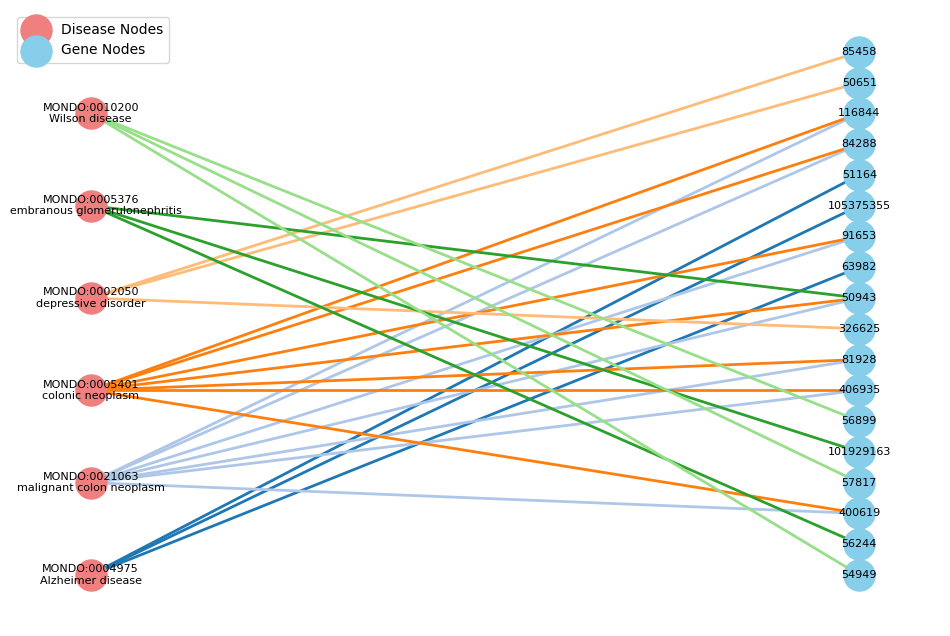

In [30]:
# Convert the PyTorch Geometric Data to a NetworkX graph and remove disease-to-disease edges
G = to_networkx(new_disgenet_torch_data, to_undirected=True)

# Filter out disease-to-disease edges (if not already done in the previous step)
disease_nodes = set(disease_mappings.values())
disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
G.remove_edges_from(disease_to_disease_edges)

# Select the first 6 disease nodes based on disease_mappings
disease_node_indices = list(disease_mappings.values())[:6]

# Limit the number of gene nodes to display per disease node
gene_limit_per_disease = 3
connected_gene_nodes = set()
for disease_node in disease_node_indices:
    neighbors = list(G.neighbors(disease_node))
    gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
    sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
    connected_gene_nodes.update(sampled_genes)

# Create a subgraph with the selected disease and limited gene nodes
subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes))

# Create a dictionary for MONDO ID to disease name mapping
mondo_to_name = dict(zip(new_disgenet_df['mondo_id'], new_disgenet_df['mondo_term']))

# Create a dictionary to label nodes with MONDO IDs, disease names, and Entrez Gene IDs
labels = {}
for disease_id, node in disease_mappings.items():
    if node in disease_node_indices:
        disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
        labels[node] = f"{disease_id}\n{disease_name}"

for gene_id, node in gene_mappings.items():
    if node in connected_gene_nodes:
        labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

# Set fixed positions for a bipartite layout
pos = {}
# Disease nodes on the left
for i, node in enumerate(disease_node_indices):
    pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

# Gene nodes on the right
for i, node in enumerate(connected_gene_nodes):
    pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

# Plotting
plt.figure(figsize=(12, 8))

# Draw disease and gene nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color="lightcoral", label="Disease Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color="skyblue", label="Gene Nodes", node_size=500)

# Color each disease's edges uniquely
colors = plt.cm.tab20.colors
for idx, disease_node in enumerate(disease_node_indices):
    disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

# Add labels with MONDO IDs, disease names, and Entrez IDs
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Add legend and display
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


<span style="color:red; font-size:35px; font-weight:bold">Step 6: Add BioGrid network gene connections to graph </span>

> #### Since I want to add as many connections as possible, adding PPI network connections from BioGRID can add more relevant information to the graph. This will add links between genes that interact with another which can be useful because genes that are highly connected to one another often are involved in biological process. This means they have similar functions and can also help create new connections during training for genes that may not be as well connected.


In [31]:
# Filter BioGRID edges based on gene IDs in `new_disgenet_torch_data`
gene_indices = set(gene_mappings.values())  # assuming `gene_mappings` is available

# Step 1: Create an edge list from the BioGRID DataFrame
biogrid_edges = []
for _, row in filtered_biogrid.iterrows():
    gene_a = row['#ID Interactor A']
    gene_b = row['ID Interactor B']
    
    # Check if both genes are in `new_disgenet_torch_data`
    if gene_a in gene_mappings and gene_b in gene_mappings:
        node_a = gene_mappings[gene_a]  # Get the index in `new_disgenet_torch_data`
        node_b = gene_mappings[gene_b]
        biogrid_edges.append([node_a, node_b])

# Step 2: Convert to tensor and add to existing edge_index
biogrid_edges = torch.tensor(biogrid_edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]

# Combine with existing edges in `new_disgenet_torch_data`
new_edge_index = torch.cat([new_disgenet_torch_data.edge_index, biogrid_edges], dim=1)

# Step 3: Update `disgenet_torch_data` with the new edges
new_disgenet_torch_data.edge_index = new_edge_index



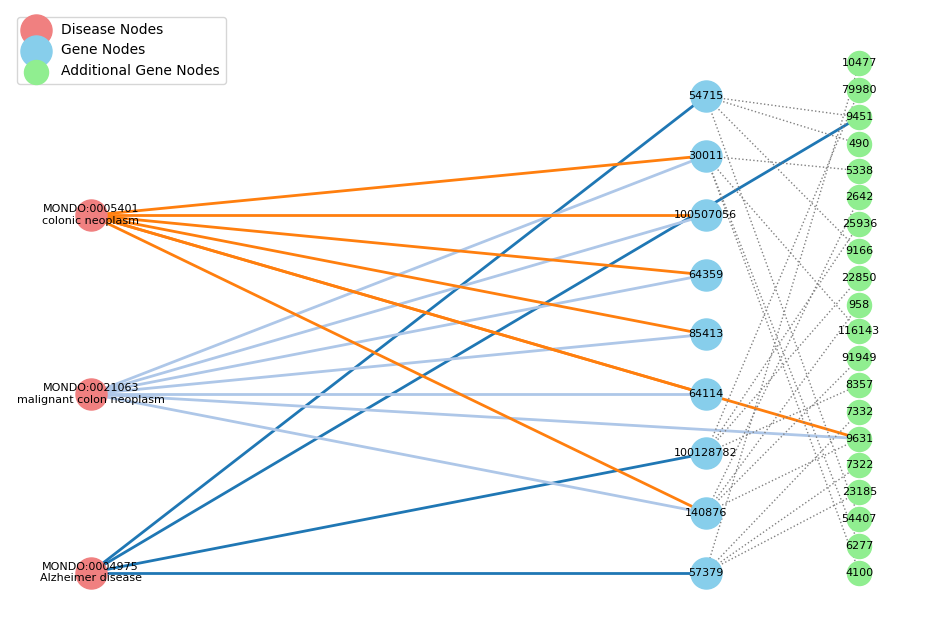

In [32]:

filtered_biogrid['#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].astype(int)
filtered_biogrid['ID Interactor B'] = filtered_biogrid['ID Interactor B'].astype(int)

# Make sure gene_mappings keys and values are also integers for consistency
gene_mappings = {int(k): int(v) for k, v in gene_mappings.items()}

# Now proceed with identifying additional genes connected to blue gene nodes
additional_gene_nodes = set()
additional_gene_edges = []
for blue_gene_node in connected_gene_nodes:
    # Filter biogrid data to find genes connected to each blue gene node
    related_genes = filtered_biogrid[(filtered_biogrid['#ID Interactor A'] == blue_gene_node) | 
                                     (filtered_biogrid['ID Interactor B'] == blue_gene_node)]
    additional_genes = set(related_genes['#ID Interactor A']).union(set(related_genes['ID Interactor B']))
    additional_genes.discard(blue_gene_node)  # Remove the blue node itself from the list
    sampled_additional_genes = random.sample(list(additional_genes), min(4, len(additional_genes)))
    
    # Add to additional gene nodes and edges
    additional_gene_nodes.update(sampled_additional_genes)
    additional_gene_edges.extend([(blue_gene_node, gene) for gene in sampled_additional_genes])


# Convert the PyTorch Geometric Data to a NetworkX graph
G = to_networkx(new_disgenet_torch_data, to_undirected=True)

# Remove disease-to-disease edges if necessary
disease_nodes = set(disease_mappings.values())
disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
G.remove_edges_from(disease_to_disease_edges)

# Select the first 6 disease nodes
disease_node_indices = list(disease_mappings.values())[:3]

# Limit the number of gene nodes to display per disease node
gene_limit_per_disease = 3
connected_gene_nodes = set()
for disease_node in disease_node_indices:
    neighbors = list(G.neighbors(disease_node))
    gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
    sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
    connected_gene_nodes.update(sampled_genes)

# Identify additional gene nodes connected to blue gene nodes
additional_gene_nodes = set()
additional_gene_edges = []
for blue_gene_node in connected_gene_nodes:
    # Filter biogrid data to find genes connected to each blue gene node
    related_genes = filtered_biogrid[(filtered_biogrid['#ID Interactor A'] == blue_gene_node) | 
                                     (filtered_biogrid['ID Interactor B'] == blue_gene_node)]
    additional_genes = set(related_genes['#ID Interactor A']).union(set(related_genes['ID Interactor B']))
    additional_genes.discard(blue_gene_node)  # Remove the blue node itself from the list
    sampled_additional_genes = random.sample(list(additional_genes), min(4, len(additional_genes)))
    
    # Add to additional gene nodes and edges
    additional_gene_nodes.update(sampled_additional_genes)
    additional_gene_edges.extend([(blue_gene_node, gene) for gene in sampled_additional_genes])

# Create a subgraph with the selected nodes
subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes) + list(additional_gene_nodes))

# Create a dictionary for node labels
labels = {}
for disease_id, node in disease_mappings.items():
    if node in disease_node_indices:
        disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
        labels[node] = f"{disease_id}\n{disease_name}"

# Label existing blue gene nodes
for gene_id, node in gene_mappings.items():
    if node in connected_gene_nodes:
        labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

# Label additional gene nodes
for gene in additional_gene_nodes:
    # If gene ID is not already labeled, add it to labels
    labels[gene] = str(gene)  # Use the gene ID itself as the label


# Set fixed positions for a clearer layout
pos = {}
# Disease nodes on the left
for i, node in enumerate(disease_node_indices):
    pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

# Blue gene nodes on the right
for i, node in enumerate(connected_gene_nodes):
    pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

# Additional gene nodes further to the right
for i, node in enumerate(additional_gene_nodes):
    pos[node] = (1.5, i * (2 / len(additional_gene_nodes)) - 1)

# Plotting
plt.figure(figsize=(12, 8))

# Draw disease and gene nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color="lightcoral", label="Disease Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color="skyblue", label="Gene Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(additional_gene_nodes), node_color="lightgreen", label="Additional Gene Nodes", node_size=300)

# Color each disease's edges uniquely
colors = plt.cm.tab20.colors
for idx, disease_node in enumerate(disease_node_indices):
    disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

# Draw edges between blue gene nodes and additional gene nodes
nx.draw_networkx_edges(subgraph, pos, edgelist=additional_gene_edges, edge_color="grey", width=1, style="dotted")

# Add labels with MONDO IDs, disease names, and Entrez IDs
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Add legend and display
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


<span style="color:red; font-size:35px; font-weight:bold">Step 7: Split data for training, testing and validation </span>

#### To train a neural net and a machine learning model you have to split your dataset into training, testing and validation. A usual rule of thumb of how to split it is 80 for training and 20% for testing (out of the testing you can do 5-10% for validation). The reason for each split is explained below but overall it is so the models are trained well and they are generalizable. Since a GNN approach is being used there are different ways you can split your training, test, and validation sets. You can either separate the edges or the nodes. In this case we are going to have the model learn from the connection between nodes which means we are splitting the edges. The edges are being split because GAEs are often used for link predictions (predicting what links should exist between different sets of nodes) and in this application it makes sense that we want to see what connections should exist between nodes based on the entire structure of the graph.

>1. **Training set** - used to train the model by updating its parameters which are values that the model learns during trainnig to make predictions and can make it possible for the model to understand the patterns that exist within the data. It's like the knobs used to minimize the error and also provide the "memory" of the model so it knows what it learned in the past and can do its best to recall it when it sees new data. **BIG PICTURE: MINIMIZE ERROR AND LEARN THE PATTERNS**


>2. **Validation set** - used during training to evaluate the model's performance on data that it hasn't seen yet. This is usefull to detect overfitting which is when the model learns TOOOO well that it can even pick up noise or just learns too many details which results in performing well in training but struggles with unseen data. This means the model is no longer generalizable. It's like memorizing all the answers to the practice test but then when you get the actual test you no longer have the same questions so you fail because you didn't understand the underlying concepts. 


>3. **Test set** - used for training and validation to assess the final performance of the model on completely unseen data. This is the true test of the model because it would reflect how it would do in a real-world setting. Also, since it hasn't seen this data then we can assume that it provides an unbiased evaulation of the model's performance.



In [33]:
# initialize device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# doing a split of 15% of edges for the test set and the 5% for validation

transform = Compose([ T.NormalizeFeatures(),
                       T.ToDevice(device),
                       T.RandomLinkSplit(num_val = 0.05, num_test= 0.15, is_undirected= True,
                                         split_labels=True, add_negative_train_samples= True),])

train_set, val_set, test_set = transform(new_disgenet_torch_data)
print("Training set: \n", train_set)
print("Validation set: \n", val_set)
print("Test set: \n", test_set)

cpu
Training set: 
 Data(num_nodes=18140, edge_index=[2, 391328], x=[18140, 1], pos_edge_label=[195664], pos_edge_label_index=[2, 195664], neg_edge_label=[195664], neg_edge_label_index=[2, 195664])
Validation set: 
 Data(num_nodes=18140, edge_index=[2, 391328], x=[18140, 1], pos_edge_label=[12228], pos_edge_label_index=[2, 12228], neg_edge_label=[12228], neg_edge_label_index=[2, 12228])
Test set: 
 Data(num_nodes=18140, edge_index=[2, 415784], x=[18140, 1], pos_edge_label=[36686], pos_edge_label_index=[2, 36686], neg_edge_label=[36686], neg_edge_label_index=[2, 36686])


<span style="color:red; font-size:35px; font-weight:bold">Step 8: Train, Test and Validate the first GAE (disease and gene graph)</span>

> #### To begin we need a way to visualize the results so two functions were made and are explained below.

#### 1. **plot_roc_curve** - function plots the ROC curve which is a way to measure how good a model is at making predicitons. It shows the balance between true positives and false positives.
#### 2. **plot_training_stats** - function plots the training and test stats. It specifically plots the AP (average precision) and AUC (area under the curve).
#####   * *AP* - is a way to measure how well a model balances precision (being correct) and recall (finding all the correct items) across different confidence levels.
#####   * *AUC*- is a way to measure how well a model can tell the difference between two classes, like "spam" and "not spam" or in this case "an edge exists" and "an edge does NOT exist"

In [34]:
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_roc_curve(title, model, data):
    model.eval()

    x = data.x
    z = model.encode(x, data.edge_index)

    pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
    neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
    preds = torch.cat([pos_preds, neg_preds], dim=0)
    preds = preds.detach().cpu().numpy()

    labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
    labels = labels.detach().cpu().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

    auc= tpr - fpr
    ix = np.argmax(auc)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.roc_auc_score(labels, preds)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--') 
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.title(title)

    # create a filename based on the title
    sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
    filename = f"../data/figures/{sanitized_title}_roc_curve.png"

    # save the plot
    #plt.savefig(filename)

    plt.show()

    plt.close()


In [35]:
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap, save_path=None):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  
  # Create a filename based on the title
  sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
  filename = f"../data/figures/{sanitized_title}_result_stats.png"

  # Save the plot
  #plt.savefig(filename)

  # Show the plot
  plt.show()

  # Close the plot to avoid displaying it multiple times in interactive environments
  plt.close(fig)
  

> #### The next two functions are used to get the final predictions of the test set. As part of the workflow they are designed to compute similarity scores between the nodes in the graph and all possible edges are ranked based on the similarity scores. An explanation of each function can be found below.

##### 1. **get_edge_dot_products**: computes the dot products between the embeddings of two nodes (the disease and gene nodes) to quantify their similairty. A similarity score helps determine which nodes are most alike based on their embeddings. In this case it is looking at what disease node is most similar to a gene node. Nodes with high similarity scores are close to another which mean they share similar properties or roles in the graph, therefore, there's a high likelihood that an edge exists between them.
##### 2. **get_ranked_edges**: function ranks all possible edges between the two groups of nodes based on the similarity scores/edge dot products. This is done to prioritize potential relationships between nodes based on the similarity nodes.

In [37]:
unique_dis = len(new_disgenet_df['mondo_id'].unique())
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb

# following two functions help get the results of the predictions after testing is done. 
def get_edge_dot_products(data, model, num_dz_nodes=unique_dis):

  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=unique_dis):

  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


In [38]:
# define the GAE
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

<span style="color:red; font-size:35px; font-weight:bold">Step 9: Run the GAE</span>

#### Now that the main functions that create the main parts of the workflow (performance metrics, GAE architecture, prediction output) then the  hyperparameter settings can be declared for the model. 
#####    * *Hyperparamters*- are the settings you can choose before training a machine larning model or neural net. These are NOT learned; they are manually set.
#### These hyperparameters are then given to the functions in charge of creating the actual GAE model. An optimizer is also declared which helps the model improve its predictions by adjusting the parameters (the settings that are automatically optimized during training). The main purpose of this step is to update these parameters so it minimizes the error/loss. 

In [39]:
# initialize the model, optimizer, and hyperparameters
input_dim = num_features
hidden_dim = 500
output_dim = 1
learning_rate = 0.005
epochs = 100

encoder = GCNEncoder(input_dim, hidden_dim, output_dim)
gae_model = GAE(encoder)
gae_model = gae_model.to(device)

###################
###################
###################
optimizer = torch.optim.AdamW(gae_model.parameters(), lr=learning_rate)
###################
###################
###################
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

gae_model.apply(weights_init)



GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1, 500)
    (conv2): GCNConv(500, 1)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)

#### The next section contains two functions that are further explained below. Then empty data containers (lists) are created to help keep track of the performance metrics for each epoch. Then these metrics are printed for each epoch. The code lines containing the writer variable are used for the tensorboard module which is helpful when you are tunning the hyperparameters and are trying to find the best optimizer for your model. 

##### 1. **gae_train** - performs a single step of training, updating the model's parameters to improve its ability to reconstruct the graph and predict edges.
##### 2. **gae_test**- valuates the model on a test dataset, providing metrics (AUC and AP) to assess how well the model generalizes to unseen data.

In [ ]:
# define the training and testing functions
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    auc, ap = gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

writer = SummaryWriter(log_dir="../data/processed/runs/gae_experiment/test")

for epoch in range(1, epochs + 1):
    loss = gae_train(train_set, gae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = gae_test(train_set, gae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = gae_test(test_set, gae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)
    
        # Log the metrics to TensorBoard
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("AUC/train", train_auc, epoch)
    writer.add_scalar("AP/train", train_ap, epoch)
    writer.add_scalar("AUC/test", test_auc_value, epoch)
    writer.add_scalar("AP/test", test_ap_value, epoch)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')
writer.close()

## use:
# tensorboard --logdir=../data/processed/runs/gae_experiment 
# on terminal to view results on tensorboard

Epoch: 001, Loss: 1.3856, Train AUC: 0.8602, Train AP: 0.8764, Test AUC: 0.8519, Test AP: 0.8690
Epoch: 002, Loss: 1.3516, Train AUC: 0.8603, Train AP: 0.8762, Test AUC: 0.8520, Test AP: 0.8689
Epoch: 003, Loss: 1.3005, Train AUC: 0.8597, Train AP: 0.8757, Test AUC: 0.8515, Test AP: 0.8684
Epoch: 004, Loss: 1.2566, Train AUC: 0.8596, Train AP: 0.8755, Test AUC: 0.8514, Test AP: 0.8682
Epoch: 005, Loss: 1.2541, Train AUC: 0.8596, Train AP: 0.8754, Test AUC: 0.8513, Test AP: 0.8681


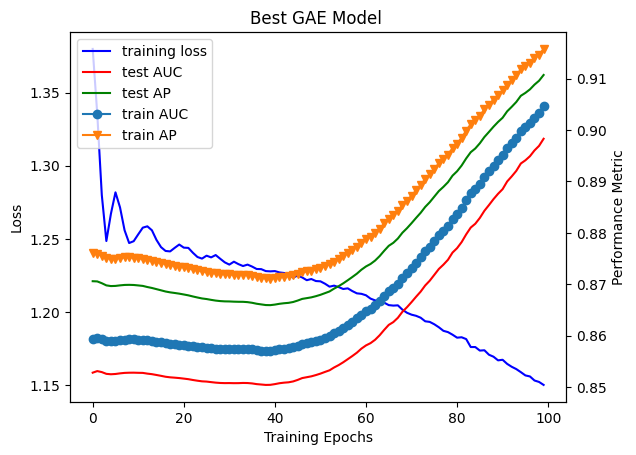

Best Threshold=0.597388


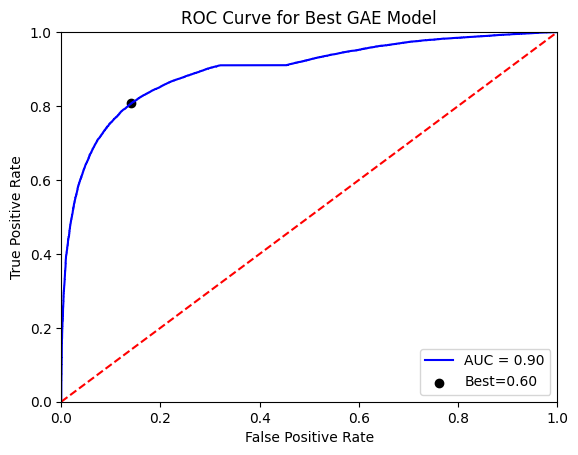

In [ ]:
plot_training_stats('Best GAE Model ', losses, test_auc, test_ap, train_aucs, train_aps)
plot_roc_curve('ROC Curve for Best GAE Model',gae_model, test_set)

>##### Getting the predictions and visualizing what the look like.

In [ ]:
gae_ranked_edge_list, gae_ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=unique_dis)

>##### Here we can see a 2D array which just means each row has 2 values/columns. The first column is the node number for the disease node. The second column is the gene node number for the gene. These two nodes are connected.

In [ ]:
gae_ranked_edge_list

array([[  852, 10237],
       [   32, 10237],
       [   18, 10237],
       ...,
       [ 4316,  8690],
       [ 3324,  8690],
       [ 4114,  8690]])

> ##### Here we can see a 1 D array that contains the dot product/similarity score value. So the 8.478 (first value) is the score for nodes 18 and 6956. *** This is verified further down.

In [ ]:
gae_ranked_dot_products

array([8.1619644e+00, 7.9847713e+00, 7.9528232e+00, ..., 6.4806460e-04,
       6.1590597e-04, 5.7700579e-04], dtype=float32)

>#### This function helps create a better visual output of the ranked and dot product prediction results.

In [ ]:
# Create reverse mappings for indices back to names
disease_name_mapping = {index: mondo_id for mondo_id, index in disease_mappings.items()}
gene_name_mapping = {index: gene_id for gene_id, index in gene_mappings.items()}

# Function to format the results using the reverse mappings, including MONDO ID and gene symbol
def format_ga_results(ranked_edge_list, ranked_dot_products, disease_name_mapping, gene_name_mapping, disgenet_with_features):
    # Convert MONDO IDs and gene IDs to names for display
    mondo_to_name = dict(zip(disgenet_with_features['mondo_id'], disgenet_with_features['mondo_term']))
    
    # Ensure gene_to_symbol uses consistent types for keys (convert to str)
    gene_to_symbol = {str(k): v for k, v in zip(disgenet_with_features['gene_id'], disgenet_with_features['gene_name'])}
    
    formatted_results = []

    for idx in range(len(ranked_dot_products)):
        disease_idx, gene_idx = ranked_edge_list[idx]
        
        # Retrieve the MONDO ID and gene ID using index mappings
        mondo_id = disease_name_mapping.get(disease_idx, f"Unknown Disease ({disease_idx})")
        gene_id = gene_name_mapping.get(gene_idx, f"Unknown Gene ({gene_idx})")
        
        # Use the MONDO ID and gene ID to get the actual names and symbols
        disease_name = mondo_to_name.get(mondo_id, mondo_id)
        gene_symbol = gene_to_symbol.get(str(gene_id), f"Unknown Gene ({gene_id})")  # Convert gene_id to str
        
        # Format each result to include MONDO ID and gene symbol
        edge_description = f"({mondo_id}-{disease_name}, {gene_id}({gene_symbol}))"
        formatted_results.append((ranked_dot_products[idx], edge_description))

    # Convert to DataFrame for easy viewing and manipulation
    results_df = pd.DataFrame(formatted_results, columns=["Dotprod", "Edges(Disease, Gene)"])
    return results_df

# Generate the formatted DataFrame
formatted_df = format_ga_results(gae_ranked_edge_list, gae_ranked_dot_products, disease_name_mapping, gene_name_mapping, disgenet_with_features)

# Display the DataFrame to check the output format
print(formatted_df.head(15))


     Dotprod                               Edges(Disease, Gene)
0   8.161964  (MONDO:0005814-intestinal cancer, 347689(SOX2-...
1   7.984771   (MONDO:0021100-breast neoplasm, 347689(SOX2-OT))
2   7.952823  (MONDO:0004989-breast carcinoma, 347689(SOX2-OT))
3   7.855142     (MONDO:0005371-mood disorder, 347689(SOX2-OT))
4   7.594830   (MONDO:0005814-intestinal cancer, 50944(SHANK1))
5   7.568275  (MONDO:0024331-colorectal carcinoma, 347689(SO...
6   7.505743  (MONDO:0002908-glucose metabolism disease, 347...
7   7.450366  (MONDO:0005814-intestinal cancer, 29127(RACGAP1))
8   7.429949     (MONDO:0021100-breast neoplasm, 50944(SHANK1))
9   7.410299   (MONDO:0005814-intestinal cancer, 51742(ARID4B))
10  7.400221    (MONDO:0004989-breast carcinoma, 50944(SHANK1))
11  7.309327       (MONDO:0005371-mood disorder, 50944(SHANK1))
12  7.288622    (MONDO:0021100-breast neoplasm, 29127(RACGAP1))
13  7.262804  (MONDO:0007179-autoimmune disease, 347689(SOX2...
14  7.259459   (MONDO:0004989-breast car

>##### Coming back to this we can see that disease node 18 is MONDO:0004989 and gene node 6956 has entrez gene id 51742. As seen in the dataframe above we have the same data above.

In [ ]:
gae_ranked_edge_list

array([[  852, 10237],
       [   32, 10237],
       [   18, 10237],
       ...,
       [ 4316,  8690],
       [ 3324,  8690],
       [ 4114,  8690]])

In [ ]:
gae_ranked_dot_products

array([8.1619644e+00, 7.9847713e+00, 7.9528232e+00, ..., 6.4806460e-04,
       6.1590597e-04, 5.7700579e-04], dtype=float32)

In [ ]:
print(gene_name_mapping)
#print(gene_mappings)
print(disease_mappings)

{0: 2, 1: 9, 2: 10, 3: 12, 4: 15, 5: 16, 6: 18, 7: 19, 8: 20, 9: 21, 10: 22, 11: 23, 12: 24, 13: 25, 14: 26, 15: 27, 16: 28, 17: 29, 18: 31, 19: 32, 20: 33, 21: 34, 22: 35, 23: 36, 24: 37, 25: 38, 26: 39, 27: 40, 28: 41, 29: 43, 30: 47, 31: 48, 32: 49, 33: 50, 34: 51, 35: 53, 36: 54, 37: 55, 38: 58, 39: 59, 40: 60, 41: 70, 42: 71, 43: 72, 44: 81, 45: 86, 46: 87, 47: 88, 48: 90, 49: 91, 50: 92, 51: 93, 52: 94, 53: 95, 54: 100, 55: 102, 56: 103, 57: 104, 58: 105, 59: 107, 60: 108, 61: 109, 62: 111, 63: 112, 64: 113, 65: 114, 66: 115, 67: 116, 68: 117, 69: 118, 70: 119, 71: 120, 72: 123, 73: 125, 74: 126, 75: 127, 76: 128, 77: 131, 78: 132, 79: 133, 80: 134, 81: 135, 82: 140, 83: 142, 84: 143, 85: 146, 86: 147, 87: 148, 88: 150, 89: 151, 90: 152, 91: 153, 92: 154, 93: 155, 94: 156, 95: 157, 96: 158, 97: 161, 98: 162, 99: 163, 100: 165, 101: 166, 102: 172, 103: 173, 104: 174, 105: 175, 106: 176, 107: 177, 108: 178, 109: 181, 110: 182, 111: 183, 112: 185, 113: 186, 114: 187, 115: 189, 116: 

#### Since my main focus was to look at predicting new connections between TB and genes, I filtered out the predictions for TB. As seen below we have 11557 predictions which is a lot more than 106 genes BUT the dotproducts are low. Regardless it gives us more gene candidates that need to be further evaluated.

In [ ]:
# filter out tb dot product results only
# Filter the DataFrame for a specific MONDO ID
specific_mondo_id = "MONDO:0018076-tuberculosis"

# Check if the MONDO ID is in the 'Edges(Disease, Gene)' column
tb_dotprod_results = formatted_df[formatted_df["Edges(Disease, Gene)"].str.contains(specific_mondo_id, regex=False)]

# Display the filtered DataFrame
tb_dotprod_results


,Dotprod,"Edges(Disease, Gene)"
257729,1.800155,"(MONDO:0018076-tuberculosis, 347689(SOX2-OT))"
306659,1.675071,"(MONDO:0018076-tuberculosis, 50944(SHANK1))"
326686,1.643209,"(MONDO:0018076-tuberculosis, 29127(RACGAP1))"
328760,1.634372,"(MONDO:0018076-tuberculosis, 51742(ARID4B))"
373079,1.587276,"(MONDO:0018076-tuberculosis, 51693(TRAPPC2L))"
...,...,...
72938921,0.040770,"(MONDO:0018076-tuberculosis, 64747(MFSD1))"
73772702,0.035041,"(MONDO:0018076-tuberculosis, 100131130(HNRNPA1..."
74512220,0.029662,"(MONDO:0018076-tuberculosis, 114088(TRIM9))"
74577380,0.029095,"(MONDO:0018076-tuberculosis, 83538(TTC25))"


##### Visually inspect the range of the dot product results for the TB gene predictions.

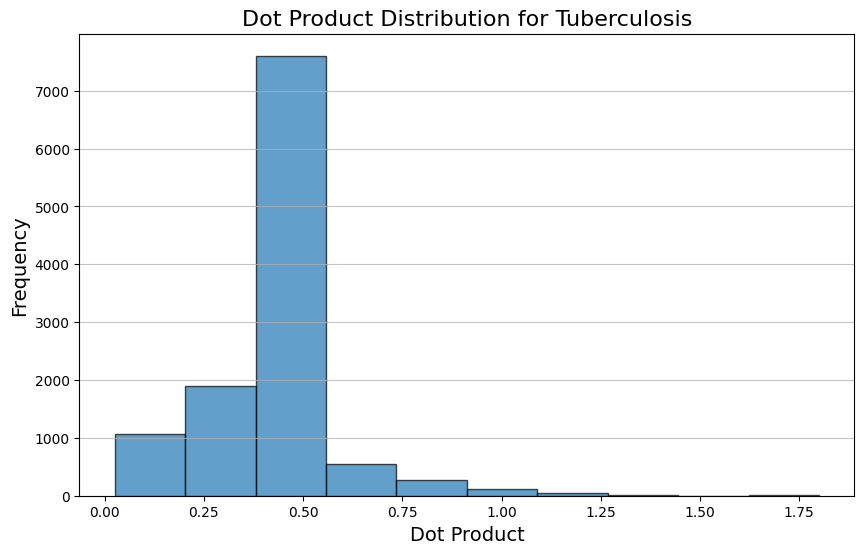

In [ ]:
# Plotting the dot product distribution for tuberculosis results
plt.figure(figsize=(10, 6))
plt.hist(tb_dotprod_results['Dotprod'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Dot Product Distribution for Tuberculosis', fontsize=16)
plt.xlabel('Dot Product', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()
